In [1]:
import scipy.stats as st
from statsmodels.formula.api import ols, rlm
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate as tb
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
%matplotlib inline

In [31]:
%precision 3

'%.3f'

# Caso 1.1.
## Estimación de una función de demanda de dinero con datos de la economía española.

En el fichero DEMDIN.GDT se ofrece información de la economía española en el periodo 1964-1985 de las siguientes variables:

- M1: Efectivo en manos del público + depósitos a la vista

- ipc: índice de precios al consumo base 1970

- rc: tipo de interés a corto plazo (tipo de los depósitos a menos de un año)

- rl: tipo de interés a largo plazo (rendimiento interno de las obligaciones privadas)

- y: PIB en unidades monetarias constantes de 1970.


>Alternativamente, los datos de M1, producción a precios
constantes y tipo de interés a corto y largo plazo, todos ellos para Europa, se
pueden obtener de la base de datos del Banco de España que se ofrece a través
del propio Gretl en la opción Archivos-Bases de datos-Sobre servidor. El dato
del IPC con base 2005 se puede obtener de la base de datos del BCE en internet.
Se pueden usar todos los datos mensuales y cuando se cargan desde Gretl se
puede decir que convierta los datos trimestrales en mensuales interpolando. Los
datos del IPC habrá que guardarlos en formato Excel y después añadirlos a los
que tengamos en Gretl, teniendo cuidado de que los decimales estén en Excel con
coma y que coincidan los periodos inicial y final.

# Se plantea estimar la siguiente función de demanda de dinero:

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

En el modelo se intenta explicar la demanda de dinero en función de la renta real, utilizándose el PIB, para estimar el efecto del motivo transacción. La segunda variable explicativa, el tipo de interés, recoge el comportamiento de la demanda de dinero especulativo, representando el coste de oportunidad de mantener dinero como forma de ahorro. La última variable, el índice de precios al consumo, se introduce como variable explicativa para valorar el efecto de la inflación sobre la demanda nominal de dinero.

- a)  Estimar el modelo de oferta monetaria, utilizando el tipo de interés a corto plazo para los grupos tipo A y el tipo a largo para los grupos tipo B. Comentar los resultados desde el punto de vista económico y econométrico.

- b)  Contrastar la restricción $β_3 = 1$, comentando sus implicaciones económicas. Hacer los cálculos paso a paso sin usar las opciones directas de Gretl.

- c)  Estimar el modelo asumiendo que la restricción es cierta.

- d)  Suponer que queremos estimar el modelo usando la variable M1 en términos reales, imponiendo para ello la restricción del apartado b), y a la vez seguir manteniendo el ipc como variable explicativa. Pensar cómo transformar el modelo para conseguir el doble objetivo anterior y calcular de forma razonada (con la ayuda de la estimación del apartado a) el valor del coeficiente que acompaña a la variable ipc.

- e)  Estimar al modelo del apartado d) comprobando si se cumple el resultado teórico.

Interpretar económicamente todos los modelos estimados y calcular en cada modelo los contrastes de especificación RESET, normalidad y autocorrelación LM de orden 1 y 2.

# MODELO:

$$log (M) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

## QUE ES UNA TRANSFORMACIÓN DEL MODELO ORIGINAL (Cobb-Douglas):

$$ M= e^{\beta_0}·y^{\beta_1}·r^{\beta_2}·ipc^{\beta_3}$$
$$ \frac{M}{ipc^{\beta_3}}= e^{\beta_0}·y^{\beta_1}·r^{\beta_2}$$

# DATOS:

Las variables usadas han sido obtenidas en la base de [datos FMI](http://data.imf.org/?sk=7CB6619C-CF87-48DC-9443-2973E161ABEB&ss=1390023474041), todas tienen frecuencia trimestral.

## Metodología:

Dado que cada serie presenta datos para un rango distinto, he fitrado el rango común para poder realizar el análisis, lo que ha reducido mucho la muestra de la series a 68 observaciones, pero suficiente para poder aplicar el teorema central del límite y la ley de los grandes números. Todas las series son para España. El rango de datos resultante va desde el primer trimestre de 1982 hasta el último trimestre de 1998.

- __M1:__ Oferta monetaria M1 (Euros) [enlace](http://data.imf.org/?sk=b6ba51fd-6647-4ca2-8e8c-e680d2660ed5&dsId=DS_1438873160033)
- __ipc:__ Indice de Precios al Consumidor, ALL ITEMS (2010 = 100%) [enlace](http://data.imf.org/?sk=37214c4f-816c-4789-a0c6-d8a4dba96f1c&dsId=DS_1438873160033)
- __rc:__ Tipo de interés de los depósitos a la vista (%) [enlace](http://data.imf.org/?sk=8bb6d92d-843b-4a2c-a147-4e009850014c&dsId=DS_1438873160033)
- __y:__ PIB real, ajustado de efecto estacional, indice (2010 = 100%) [enlace](http://data.imf.org/?sk=c7fe04cd-fbbf-4f6b-b7d2-cd13a9fa5122&dsId=DS_1438873160033)

In [32]:
# datos
r = pd.read_excel('fmi_interes_spain.xlsx', skip_rows=0, header=1, index_col=0) / 100  # tanto por uno
r.columns = ['r']

In [33]:
p = pd.read_excel('fmi_ipc_spain.xlsx', skip_rows=0, header=1, index_col=0)
p.columns = ['p']

In [34]:
m1 = pd.read_excel('fmi_m1_spain.xlsx', skip_rows=0, header=1, index_col=0)
m1.columns = ['m1']

In [35]:
y = pd.read_excel('fmi_pib_spain.xlsx',skip_rows=0, header=1, index_col=0)
y.columns = ['y']

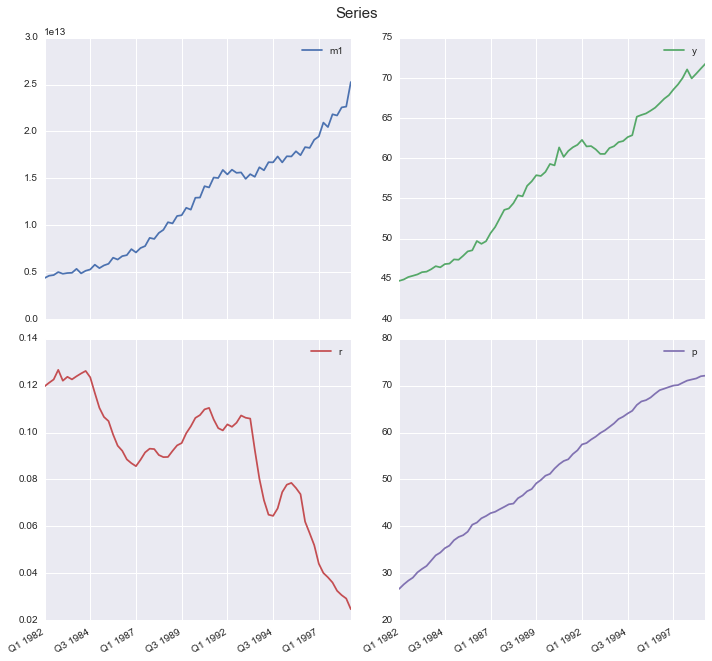

In [36]:
data = pd.concat([m1 , y, r, p], axis=1, join='inner')
data.dropna(inplace=True)
data.plot(subplots=True, layout=(2,2), figsize=(10,9))
plt.tight_layout()

plt.suptitle('Series', y=1.015, fontsize=15)
plt.savefig('imgs/series.png', bbox_inches='tight')

Los gráficos nos indican que las variables presentan tendencia determinista, excepto el caso del tipo de interés que no está muy claro. Para identificar mejor los componentes deberíamos hacer un contraste de dickey-fuller para todas y decidir a partir de la información recogida. A priori podemos decir que el tipo de interés tiene una tendencia mas volátil y decreciente, mientras que el resto son más estables y con tendencia creciente respecto del tiempo.

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


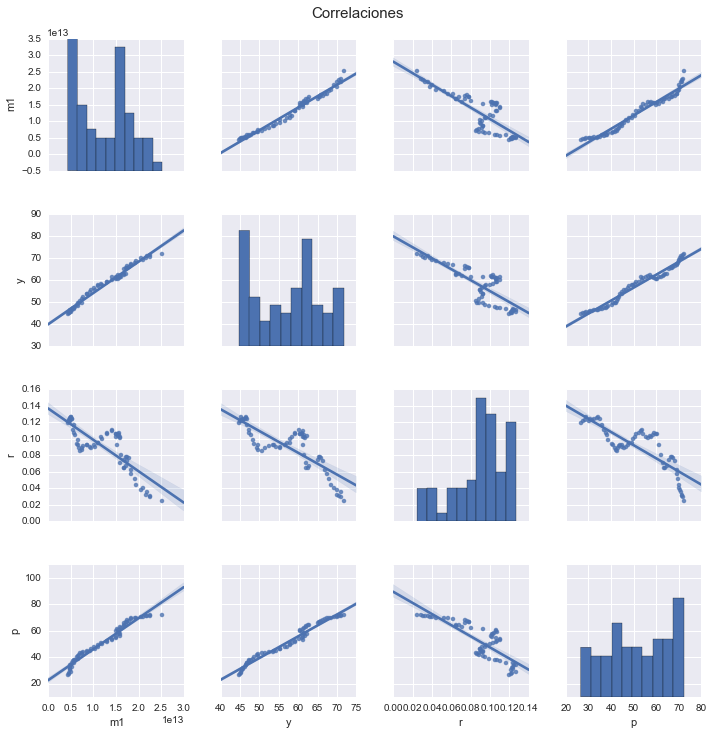

In [37]:
g = sns.pairplot(data=data, kind='reg')
plt.tight_layout()
plt.suptitle('Correlaciones', y=1.015, fontsize=15)

In [38]:
print(data.head())

                    m1          y         r          p
Q1 1982  4363000000000  44.744559  0.119700  26.637351
Q2 1982  4611700000000  44.912734  0.121233  27.584677
Q3 1982  4684000000000  45.216270  0.122633  28.391079
Q4 1982  5003400000000  45.375656  0.126733  29.040898
Q1 1983  4821800000000  45.541487  0.122100  30.160465


In [39]:
print(data.tail())

                     m1          y         r          p
Q4 1997  21834900000000  71.054916  0.036000  71.072951
Q1 1998  21705700000000  69.937077  0.032467  71.310435
Q2 1998  22567600000000  70.530850  0.030600  71.534871
Q3 1998  22653200000000  71.158433  0.029167  72.004619
Q4 1998  25270600000000  71.763124  0.024633  72.135105


## MODELO A

In [86]:
# regresión
formula = 'np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)'
results = ols(formula, data).fit().get_robustcov_results()
print('$'+ formula+'$')
print('\n')
print(results.summary())

$np.log(m1) ~ np.log(y) + np.log(r) + np.log(p)$


                            OLS Regression Results                            
Dep. Variable:             np.log(m1)   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2296.
Date:                Sat, 31 Oct 2015   Prob (F-statistic):           4.57e-65
Time:                        20:35:48   Log-Likelihood:                 107.11
No. Observations:                  68   AIC:                            -206.2
Df Residuals:                      64   BIC:                            -197.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
I

Estimando el mismo modelo pero con estimaciones robustas, no sulucionamos los problemas de heterocedasticidad pero al menos nos aseguramos que los t-ratios y el estadístico F siguen sus correspondientes distribuciones. Por tanto, usaremos estos errores estandar para hacer los contrastes.

A partir de la información obtenida del modelo, analizamos el **Durbin-Watson** que contrasta la no autocorrelación, está entre 0 y 4, con un DW cerca de 0 correlación positiva y cerca de 4 correlación negativa. 

$H_0 = \rho = 0$

A priori, parece haber autorcorrelación, pero **no está claro** con un DW de 1.128 > 1, $\hat{\rho} = 1 - \frac{1.128}{2} = 0.436$ con $-1< \rho < 1$ estaríamos indecisos solo con este contraste, por lo que necesitamos __más información__ al respecto. 

La prueba de **Jarque-Bera** nos da información sobre la normalidad de las perturbaciones, con un JB = 1.785 y p-value = 0.410, **no hay evidencia que sugiera rechazar** la hipótesis de normalidad de las perturbaciones. El contraste **Omnibus** también da evidencia a **favor de la normalidad.**

Nos faltaría información acerca de la correcta **especificación** y sobre la **heterocedasticidad** que calcularemos a continuación.

Tras este breve análisis, se puede concluir que el modelo es significativo conjuntamente, los parámetros lo son individualmente y además con un $R^2 = 0.991$ por lo que el modelo explica practicamente la totalidad del comportamiento de la variable endógena.

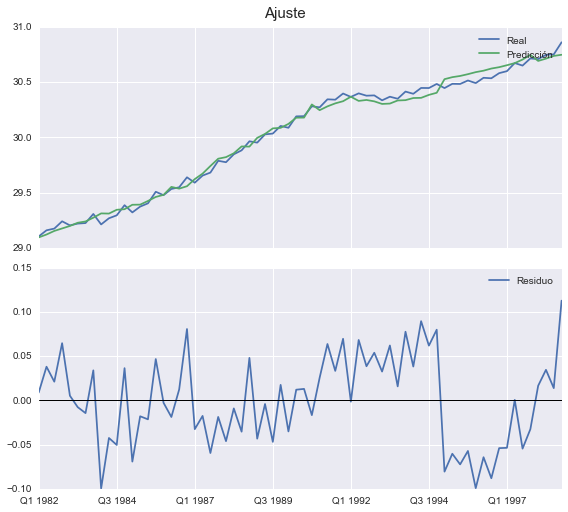

In [41]:
data_log = np.log(data)
fig=plt.figure(figsize=(8,7))

ax1 = plt.subplot(2,1,1)
data_log.m1.plot(label='Real', ax=ax1)
results.fittedvalues.plot(label='Predicción')

ax2 = plt.subplot(2,1,2)
results.resid.plot(ax=ax2, label='Residuo', sharex=ax1)
ax2.axhline(y=0, color='black', linewidth=1)

ax1.legend()
ax2.legend()
plt.suptitle('Ajuste', fontsize=15, y=1.01)
plt.tight_layout()
plt.savefig('imgs/ols_ajuste.png', bbox_inches='tight')

En el primero de los gráficos está representado la endógena real y la estimada, se ve como la estimación se ajusta muy bien a la realidad (endógena), aunque sabemos que presenta problemas.

El segundo es el gráfico de los residuos, a partir de 1989 parece presentar un comportamiento no estocástico, esto lo tendremos en cuentra para aplicar los contrastes.

## AUTOCORRELACIÓN

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


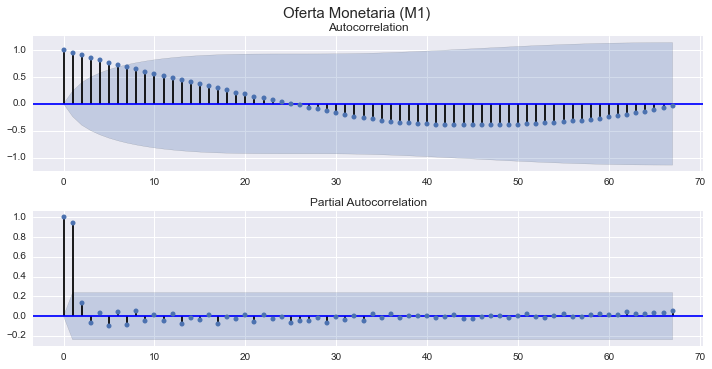

In [42]:
# desde aqui
fsize = (10,5)

plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.m1, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.m1, ax=ax2)
plt.suptitle('Oferta Monetaria (M1)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/m1_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


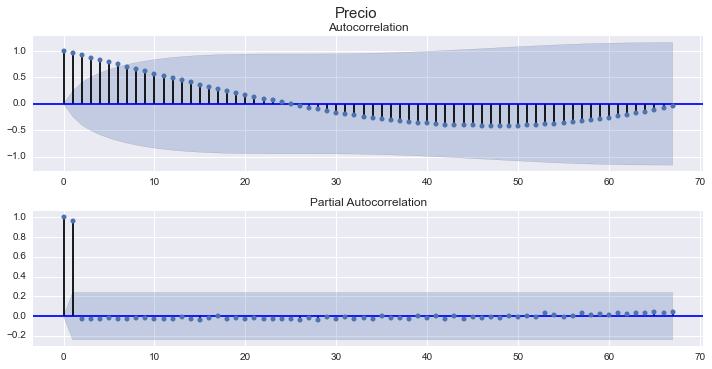

In [43]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.p, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.p, ax=ax2)
plt.suptitle('Precio', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/p_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


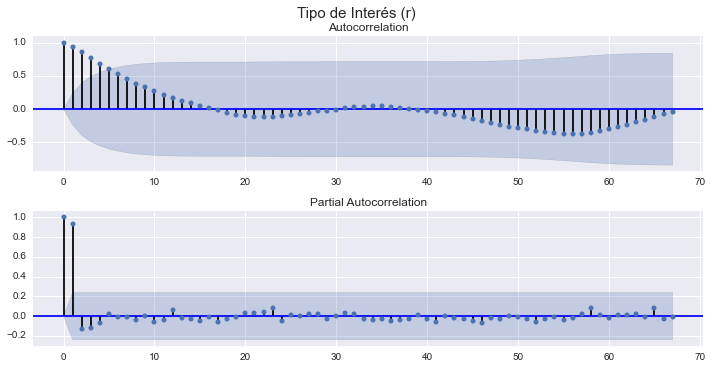

In [73]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)

plot_acf(data.r, ax=ax1)
ax2 = plt.subplot(2,1,2)

plot_pacf(data.r, ax=ax2)
plt.suptitle('Tipo de Interés (r)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/r_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


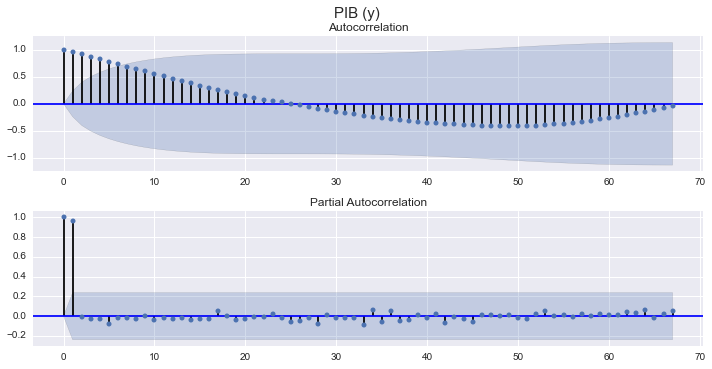

In [74]:
plt.figure(figsize=fsize)
ax1 = plt.subplot(2,1,1)
plot_acf(data.y, ax=ax1)
ax2 = plt.subplot(2,1,2)
plot_pacf(data.y, ax=ax2)
plt.suptitle('PIB (y)', fontsize=15, y=1.015)
plt.tight_layout()
plt.savefig('imgs/y_acor.png', bbox_inches='tight')

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


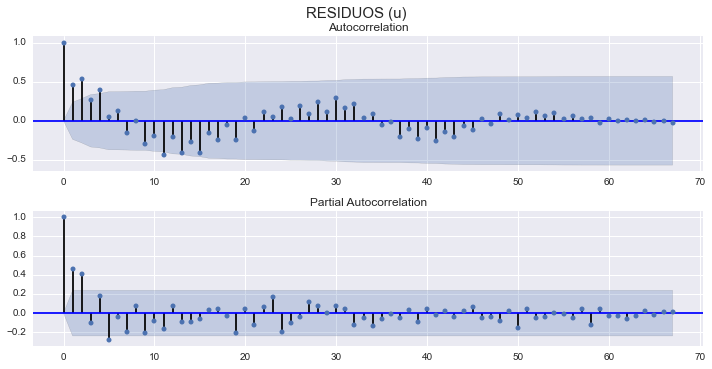

In [76]:
plt.figure(figsize=fsize)

ax1 = plt.subplot(2,1,1)
plot_acf(reg.resid, ax=ax1)

ax2 = plt.subplot(2,1,2)
plot_pacf(reg.resid, ax=ax2)

plt.suptitle('RESIDUOS (u)', fontsize=15, y=1.015)
plt.tight_layout()

plt.savefig('imgs/u_acor.png', bbox_inches='tight')

In [87]:
# contraste de autocorrelación de Breusch-Godfrey

print('## Contraste de Aucorrelación de Breusch-Godfrey:')
name = ['LM', 'P-value', 'F-test', 'P-value']
for i in range(1,5):
    test = sms.acorr_breush_godfrey(results, nlags=i)
    test = np.round(test, 4)
    print('BG(%s): %s\t p-value: %s' % (i, test[0], test[1]))

## Contraste de Aucorrelación de Breusch-Godfrey:
BG(1): 11.9649	 p-value: 0.0005
BG(2): 23.8191	 p-value: 0.0
BG(3): 24.313	 p-value: 0.0
BG(4): 28.2185	 p-value: 0.0


Contraste LM de Breusch-Godfrey, para LM(i) con i = 1,...,4, nos dice que hay evidencia a favor de la autocorrelación de los residuos para cada orden i.

In [88]:
# contraste de autocorrelación de ljun-box:
print('## Contrsaste de Aucorrelación de LJung-Box')
name = 'lbvalue pvalue'.split(' ')
test = sms.acorr_ljungbox(results.resid, lags=13)
test = np.round(test, 4)
print(pd.DataFrame([test[0], test[1]], index=name).T)


## Contrsaste de Aucorrelación de LJung-Box
    lbvalue  pvalue
0   11.2697  0.0008
1   30.3604  0.0000
2   33.2391  0.0000
3   44.3385  0.0000
4   44.4357  0.0000
5   45.3130  0.0000
6   48.8166  0.0000
7   48.8758  0.0000
8   55.9465  0.0000
9   56.8175  0.0000
10  67.5557  0.0000
11  67.9257  0.0000
12  76.6743  0.0000


El contraste de Ljung-Box contrasta conjuntamente la autocorrelación de orden i. La primera columna nos da el valor del LB y la segunda el p-value, que nos da evidencia en contra de la hipótesis de no autocorrelación.

Por tanto el modelo presenta problemas de autocorrelación, este problema es típico con datos de series temporales, y se puede corregir añadiendo retardos, diferenciando, conviertiendo las series en estacionarias o cambiando los datos por corte trasnversal.

## HETEROCEDASTICIDAD

In [89]:
# constraste heterocedasticidad breush-pagan
print('## Contraste de Heterocedasticidad (Breusch-Pagan):')
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
bp, pvalue = np.round(sms.het_breushpagan(results.resid, results.model.exog)[:2], 3)
print('BP: %s \t p-value: %s' % (bp, pvalue))

## Contraste de Heterocedasticidad (Breusch-Pagan):
BP: 8.049 	 p-value: 0.045


El contraste LM de Breusch-Pagan (BP) no informa de la presencia de homocedasticidad o ausencia de ella. Para un nivel de significación del 5% estrictamente no podemos aceptar la hipótesis nula de homocedasticidad pero al estar tan próximo de la región de aceptación, necesitamos más información.

El contraste de breush-pagan plantea la siguiente regresión auxiliar:

$\hat{u}^2 = \gamma_0 + \gamma_1 x + v$ y contrasta $\gamma_0 = \gamma_1 = 0$.

In [90]:
# constraste heterocedasticidad Golfeld-Quandt

print('## Contraste de Heterocedasticidad (Goldfeld-Quandt):')
name = ['F statistic', 'p-value']
test, pv = np.round(sms.het_goldfeldquandt(results.resid, results.model.exog)[:2], 3)
print('GQ ~ F : %s\tpvalue: %s' % (test, pv))


## Contraste de Heterocedasticidad (Goldfeld-Quandt):
GQ ~ F : 0.747	pvalue: 0.785


Para buscar más información que nos permita arrojar luz sobre la homocedasticidad del modelo, nos fijamos en los resultados del contraste de Goldfeld-Quandt que nos dice que se acepta la hipótesis nula de homocedasticidad. Este test suele usarse cuando pensamos que la varianza de la perturbación tiene una relación proporcional al valor de una de la varianza de una de las variables explicativas.

In [91]:
# constraste homocedasticidad
test, pv = np.round(sms.het_arch(results.resid)[:2], 4)
print('Contraste LM ARCH: %s\tpvalue: %s' %(test, pv))

Contraste LM ARCH: 22.7763	pvalue: 0.019


Si la la varianza del error depende de la varianza del error en periodos anteriores, entonces este contraste lo recogería. La hipótesis nula es la ausencia de componentes ARCH frente a la alternativa de presencia.

In [92]:
test, pv = np.round(sms.het_white(results.resid, results.model.exog)[:2], 4)
print('White: %s\tpvalue:%s' % (test, pv))

White: 14.7567	pvalue:0.0978


El contraste de white, es muy sensible a la mala especificación del modelo y a la precencia de componentes ARCH. Por lo que no es fiable.

$$ y_t = a_0 + a_1 y_{t-1} + \cdots + a_q y_{t-q} + \epsilon_t = a_0 + \sum_{i=1}^q a_i y_{t-i} + \epsilon_t$$

Se obtiene el cuadrado del error: $\hat \epsilon^2 $ y se hace la regresión:
$$ \hat \epsilon_t^2 = \hat \alpha_0 + \sum_{i=1}^{q} \hat \alpha_i \hat \epsilon_{t-i}^2$$
donde q es la cantidad de retardos.

La hipótesis nula es que $\alpha_i = 0$ $\forall i=1,..,q$

En una muestra de T residuos bajo la hipótesis nula de ausencia de componentes ARCH en los errores, el estadístico $T'R^2 ~\chi^2_{q}$, donde T' es el número de ecuaciones en el modelo que ajustan el residuo contra los retardos. (T'=T-q).

## ESPECIFICACIÓN

In [96]:
# contraste de especificacion RESET
print('## Contraste de RESET')

reset = 'm1 ~ y + r + p + y_hat2 + y_hat3'

d = np.log(data).copy()

d['y_hat2'] = results.predict() ** 2
d['y_hat3'] = results.predict() ** 3
res = ols(reset, d).fit()
h0 = 'y_hat2 = y_hat3 = 0'
test = res.f_test(h0)
pv = np.round(test.pvalue, 4)
print('\nF-test: %s\tpvalue: %s' % (np.round(test.fvalue[0][0], 4), pv))

## Contraste de RESET

F-test: 15.1726	pvalue: 0.0


El test de RESET contrasta la correcta especificación o no del modelo, introduciendo en el modelo original la endógena al cuadrado y al cubo si el modelo esta correctamente especificado entonces los parámetros que acompañan a las endógenas al cuadrado y al cubo deberán ser cero. En este caso vemos que el contraste reset no da evidencia en contra de la hipótesis nula, por tanto hay evidencia a favor de que el modelo está mal especificado.

## SIGNIFICATIVIDAD Y CONTRASTES

In [97]:
# contraste b3=1
print('## Contraste de $\\beta_3 = 1$')
h0 = 'np.log(p) = 1'
t_test = results.t_test(h0)
print(t_test)

## Contraste de $\beta_3 = 1$
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             0.3982      0.097     -6.208      0.000         0.205     0.592


El contraste t-ratio para $\beta_3 = 1$ que se obtiene dividiendo el parámetro por su error estándar, sigue una t-student de N - k - 1 grado de libertad. Suponiendo que las muestras provienen de una población normal.

## ¿SE CUMPLEN LOS SUPUESTO DEL MODELO LINEAL GENERAL?

### AUTOCORRELACIÓN

Para comprobar que las perturbaciones sean independientes, he aplicado los contrastes de Breusch-Godfrey y Ljun-Box, y ambos proporcionan evidencia en contra de la hipótesis nula, por tanto no aceptamos la hipótesis nula de no autocorrelación.

Por tanto el modelo evidencia __autocorrelación__.

### HOMOCEDASTICIDAD

Aplicamos los contrastes de Breusch-Pagan (BP) y Goldfeld-Quandt (GQ) y encontramos cierta contradicción entre los contrastes, pues el contraste BP nos da una evidencia muy debil en contra de la hipótesis nula, para un nivel de significación del 5% se obtiene un p-value = 4,5% lo que estrictamente lleva a rechazar $H_0$. 

Por otro lado el contraste Goldfeld-Quandt nos proporciona evidencia clara a favor la hipótesis nula.

Dado que el GQ da un p-value mucho más determinante, que el resto, parece razonable suponer que hay mayor evidencia a favor de $H_0$ que en contra.

Sin embargo el contrate ARCH, nos dice que puede haber evidencia para suponer que la varianza de los residuos depende del pasado de los propios residuos.

Por tanto modelo evidencia __homocedasticidad__ según GQ y White, pero __heterocedasticidad__ según ARCH, BP.

### ESPECIFICACIÓN

El contraste de RESET nos dá información acerca de la correcta especifiación del modelo, y obtenemos que hay evidencia a en contra de la hipótesis nula ($\gamma_0 = \gamma_1 = 0$), por tanto el modelo puede estar mal especificado. Hay que tener en cuenta que este problema pueda deberse a los problemas de autocorrelación.

Por tanto el modelo evidencia una __mala especificación__.

### NORMALIDAD

Para validar la normalidad en las perturbaciones, aplicamos el contraste de Jarque-Vera que nos dá evidencia a favor de la normalidad.

Por tanto el modelo evidencia __normalidad.__

### SIGNIFICATIVIDAD

De haberse cumplido los supuestos del MLG, los parámetros estimados se pueden interpretar y si son todos significativos, tanto individual como conjuntamente, razonar en términos económicos.

El modelo con un $R^2 = 0.991$ explica prácticamente todo el comportamiento de la variable endógena, el $\hat{R}^2 = 0.99$.


# APARTADO A

## El modelo planteado:

$$ log(M1) = \beta_1 log(y) + \beta_2 log(r) + \beta_3 log(p) + u$$

Planteamos un modelo MCO para la regresión anterior y obtenemos los siguientes resultados:

### PRINCIPALES RESULTADOS

In [99]:
for i, (b, se) in enumerate(zip(results.params, results.bse)):
    b, se = np.round([b,se], 4)
    print('$\\beta_%s = %s (%s)$' % (i,b,se))

$\beta_0 = 16.7194 (0.4169)$
$\beta_1 = 2.963 (0.191)$
$\beta_2 = 0.091 (0.0262)$
$\beta_3 = 0.3982 (0.0969)$


Con todos los parámetros significativos y una vez comprobado que se cumplen los supuestos del modelo lineal general (recordar que en este modelo no se cumple dado que presenta problemas de especificación y autocorrelación), poddríamos interpretar el modelo en términos económicos.

Si pasamos por alto los problemas del modelo vemos que estamos ante un modelo __doblemente logarítmico__ y que por tanto tenemos que interpretar los parámetros de posición como __elasticidades__, esto es, el efecto del incremento de un punto porcentual que afecta a la oferta monetaria, exceptuando el caso del tipo de interés (r) cuyas unidades son porcentajes (%) lo que dificulta su interpretación.

### EL TÉRMINO INDEPENDIENTE ($\beta_0$)

Vemos por tanto que la interpretación del término __independiente ('Intercept')__ es que si no se producen cambios en la renta, precios y el tipo de interés la oferta monetaria tiene un valor que tenemos que hallar, este valor es:

$log(M1) = \beta_0$

$e^{log(M1)} = e^{\beta_0}$

$M1 = e^{\beta_0} $

$M1 = e^{16.7194} = 18244645.111$

### EL EFECTO DE LA RENTA (y) EN LA OFERTA MONETARIA ($\beta_1$)

El $\beta_1 = 2.9630$ nos dice que incrementos de un 1% en la renta, tiene un efecto de 2.9630% en la oferta monetaria, casi 3 veces más intenso relativamente. Esto tiene sentido ya que por teoría, sabemos que la demanda de dinero tiene efecto positivo en la demanda de dinero (demanda de dinero motivo transacción).

### EL EFECTO DEL TIPO DE INTERÉS (r) EN LA OFERTA MONETARIA ($\beta_2$)

El $\beta_2  = 0.0910$ nos dice que aumentos del 1% del tipo de interés(%), tiene un efecto del 0.0910% sobre la oferta de dinero. Teniendo en cuenta que para el modelo planteado la oferta monetaria es exógena, y el tipo de interés (r) es endógena, esto nos indica cómo debería cambiar la oferta monetaria para conseguir un cambio en el tipo de interés, así pues:

$\frac{d(M)}{M} = \beta_2 d(r)$

$\frac{1}{\beta_2} · \frac{d(M)}{M} = d(r)$

$\frac{1}{0.0910} · \frac{d(M)}{M} = d(r)$

$10.989011 \frac{d(M)}{M} = d(r)$

Es importante notar que el signo del $\beta_2$ es el mismo que el $m_r$, según la teoría nos dice que $m_r < 0$ por lo tanto tenemos una __contradicción__ con la realidad. Al ser de un 0.0910 muy pequeño nos podría indicar que la elasticidad de la oferta monetaria al tipo de interés está próxima a cero (inelástica). Esto podría interpretarses como una situación en la economía tenga una política monetaria inefectiva, en el modelo keynesiano a esto se le denomina trampa de la liquidez. Pero esta interpretación podría ser totalmente errada ya que tenemos que recordar que el modelo presenta problemas de autocorrelación, heterocedasticiadad y por tanto los coeficientes no tienen interpretación causal.

### EL EFECTO DEL PRECIO SOBRE LA OFERTA MONETARIA ($\beta_3$)

El $\beta_3 = 0.3982$ nos dice que si aumentan los precios en un 1%, la oferta monetaria lo hace en un 0.3982%, es decir, que si hay inflación la oferta monetaria aumenta relativamente menos de la mitad. Esto tiene sentido con lo que nos dice la Teoría Económica, ya que:

$\frac{M}{P} = m(r,y)$

$log(\frac{M}{P} = log[m(r,y)]$

$log(M) - log(P)  = log[m(r,y)]$

$log(M) = log[m(r,y)] + log(P)$

__DERIVANDO:__

$\frac{d(M)}{M} = \frac{m_r·d(r) + m_y · d(y)}{m(r,y)} + \frac{d(P)}{P}$ con dr, dy = 0

$\frac{d(M)}{M} = \frac{d(P)}{P}$

Por lo tanto aumentan en la misma dirección. Importante notar que en un esquema de modelo Keynesiano o Clásico, P es una variable endógena mientras que M es exógenas, para esta última, es importante notar que las autoridades monetarias deciden M y no r como es en la realidad.

# APARTADO B
Contrastar la restricción $β_3=1$, comentando sus implicaciones económicas. 
Hacer los cálculos paso a paso sin usar las opciones directas de Gretl.

In [108]:
results.bse[-1]

0.097

In [109]:
results.params[-1]

0.398

In [110]:
(results.params[-1] - 1) / results.bse[-1]

-6.208

Para contrastar $\beta_3 = 1$, tenemos dos opciones, plantear un contraste F o t, dado que es más sencillo un contraste t-ratio, el procedimiento a seguir es:

## Hipótesis

$H_0: \beta_3 = 1$

$H_1: \beta_3 ≠ 1$

## Contraste

$t = \frac{\hat{\beta_3} - \beta_3}{\sigma_{\hat{\beta_3} / \sqrt{N}}}$

$t = \frac{0.39820 - 1}{0.097} = -6.208$

## Región Crítica

N = 68

n = 68 - 4 (En este caso la t tiende en distribucion a una normal)

gl = 63

α = 0.05

$t < t_{(n-1 , \alpha / 2)}$

$t < t_{(63 , 0.025)}$

$t_{(63 , 0.025)} = -1.9983$

$-6.208 < -1.9983 \rightarrow$ Nos indica que hay evidencia en contra de la hipótesis nula, por tanto rechazamos $H_0: \beta_3 = 1$

In [105]:
data_log = np.log(data)

df = len(data_log)-4-1
beta_hat = results.params[-1]
beta_h0 = 1
se = results.bse[-1]
tratio = (beta_hat - beta_h0) / se
alpha = 0.05
tscore = st.t.ppf(alpha / 2, df=df)

txt = ''' ## Contraste con los datos
Grados de Libertad = %s

$\\hat{\\beta}$ = %s

$\\beta_{H_0}$ = %s

Error Estandar = %s

t-ratio = %s

$\\alpha = %s$

punto crítico = %s''' % (df, beta_hat, beta_h0, se, tratio, alpha, tscore)

print(txt)

 ## Contraste con los datos
Grados de Libertad = 63

$\hat{\beta}$ = 0.39817409979

$\beta_{H_0}$ = 1

Error Estandar = 0.0969435772227

t-ratio = -6.2080017826

$\alpha = 0.05$

punto crítico = -1.99834054177


/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


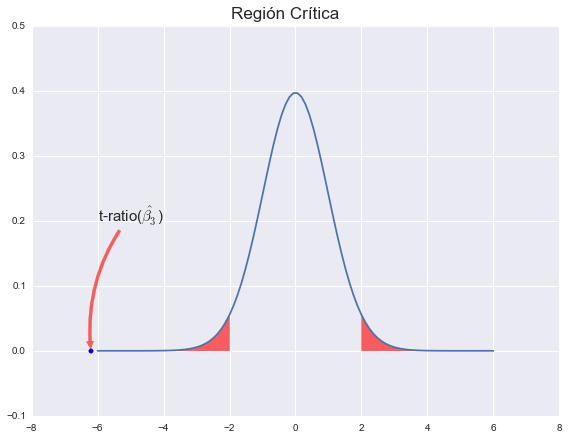

In [106]:
plt.figure(figsize=(8,6))
# pintar la distribución t-student teórica
x = np.linspace(-6,6,100)
y = st.t.pdf(x, df=df)
plt.plot(x, y)

# sombrear la región crítica
plt.fill_between(x=x[x<= -1.998], y1 = y[:len(x[x<= -1.998])], color = 'red', alpha=0.6)
plt.fill_between(x=x[x>= 1.998], y1 = y[-len(x[x>= 1.998]):], color='red', alpha=0.6)

# dibujar el punto del t-ratio
plt.scatter(tratio, 0)

# anotar el punto t-ratio
plt.annotate(xy = (tratio,0), 
             xytext = (-6, 0.2), 
             s=r't-ratio($\hat{\beta_3}$)',
             fontsize=15,
             xycoords='data', 
             arrowprops=dict(arrowstyle="simple, tail_width=0.2", 
                             connectionstyle="arc3,rad=.2", 
                             color='red', 
                             alpha=0.6))
# título
plt.suptitle('Región Crítica', fontsize=17, y=1.01)

plt.tight_layout()
plt.savefig('imgs/rc.png', bbox_inches='tight')

El gráfico muestra la representación gráfica de la prueba t-ratio para el caso de $\beta_3 = 1$

### Contraste con los datos
Grados de Libertad = 63

$\hat{\beta}$ = 0.3982

$\beta_{H_0}$ = 1

Error Estandar = 0.0969435772227

t-ratio = -6.20773461472

$\alpha = 0.05$

punto crítico = -1.99834054177
Vamos a tener en cuenta que para una muestra grande la t-student converge en distribución a una Normal estandar.
punto crítico = -1.96

### p-value

$P\{t < t_{contraste}\} < \alpha$

Notar que dado que se trata de un contraste bilateral, basta compara el valor que queremos contrastar con el intervalo de confianza de $\hat{\beta}_3$, si el intervalo contiene a dicho valor entonces no se rechaza $H_0$, de lo contrario rechazaríamos la hipótesis nula.

In [111]:
txt2 = '''$P-value = P\{ t < |t-ratio|\} = %s$''' % round(st.t.cdf(tratio, df=df) * 2, 9)
print(txt2)

$P-value = P\{ t < |t-ratio|\} = 4.7e-08$


Por tanto, los tres indicadores (P-Value, Punto Crítico, Intervalo de Confianza) nos dicen que hay evidencia suficiente para rechazar la hipótesis nula o equivalentemente existe evidencia para afirmar que $\beta_3 ≠ 1$.

Un $\beta_3 = 1$ implica que la oferta monetaria tiene una relación proporcional directa respecto de los precios.

# APARTADO C

Estimar asumiendo que $\beta_3 = 1$, para ello tenemos que hacer unos cambios en el modelo inicial.

Modelo Inicial: 

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + β_3 log (ipc) + u$$

Sustituyendo $\beta_3 = 1$:

$$log (M1) = β_0 + β_1 log (y) + β_2 log (r) + log (ipc) + u$$

$$log (M1) - log (ipc) = β_0 + β_1 log (y) + β_2 log (r) + u$$

Esta última es la ecuación que vamos a estimar.

In [112]:
formula_c = 'np.log(m1) - np.log(p) ~ np.log(y) + np.log(r)'
modelo = ols(formula_c, data)

reg = modelo.fit().get_robustcov_results()
#endog.name = 'logM1-logP'

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             np.log(m1)   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3242.
Date:                Sat, 31 Oct 2015   Prob (F-statistic):           7.86e-66
Time:                        20:45:43   Log-Likelihood:                 100.60
No. Observations:                  68   AIC:                            -195.2
Df Residuals:                      65   BIC:                            -188.6
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.1432      0.225     67.451      0.0

- Según el DW parece haber presencia de autocorrelacón.
- El JB nos informa que los residuos siguen una distribución normal.
- Suponiendo cumplimiento de las hipótesis:
    - Los parámetros son significativos individualmente y conjuntamente.
    - R^2 nos dice que el modelo explica el 93.9% del comportamiento de la endógena.
- $\beta_0 = 15.143$
- $\beta_1 = 3.7423$ % que aumenta m/p por aumentos en un 1% de y.
- $\beta_2 = 0.0983$ % que aumenta m/p por aumentos en un 1% de r(%).

In [113]:
reg.t_test([0,1,0])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             3.7423      0.067     56.265      0.000         3.609     3.875

In [128]:
t = reg.f_test([0,1,1])

print('F: %s\tpvalue: %s' % (np.round(t.fvalue[0][0], 4), np.round(t.pvalue, 4)))

F: 1941.7861	pvalue: 0.0


In [129]:
print(sms.anova_lm(reg))

           df     sum_sq    mean_sq            F        PR(>F)
np.log(y)   1  18.379454  18.379454  5784.561958  3.050297e-65
np.log(r)   1   0.044524   0.044524    14.013098  3.869733e-04
Residual   65   0.206526   0.003177          NaN           NaN


In [135]:
# autocorrelación
for i in range(1,9):
    t = np.round(sm.stats.diagnostic.acorr_breush_godfrey(reg, nlags=i)[:2], 4)
    print('BG(%s): %s\tpvalue: %s' % (i, t[0], t[1]))

BG(1): 15.0057	pvalue: 0.0001
BG(2): 24.6039	pvalue: 0.0
BG(3): 25.0148	pvalue: 0.0
BG(4): 27.0098	pvalue: 0.0
BG(5): 30.7664	pvalue: 0.0
BG(6): 30.9581	pvalue: 0.0
BG(7): 32.2556	pvalue: 0.0
BG(8): 32.4338	pvalue: 0.0001


In [140]:
for i in range(12):
    lj = np.round(sms.acorr_ljungbox(reg.resid, lags=12), 3)
    print('LJ(%s): %s\tpvalue: %s' % ((i+1), lj[0][i], lj[1][i]))

LJ(1): 14.895	pvalue: 0.0
LJ(2): 35.63	pvalue: 0.0
LJ(3): 40.933	pvalue: 0.0
LJ(4): 52.394	pvalue: 0.0
LJ(5): 52.6	pvalue: 0.0
LJ(6): 53.79	pvalue: 0.0
LJ(7): 55.67	pvalue: 0.0
LJ(8): 55.67	pvalue: 0.0
LJ(9): 63.051	pvalue: 0.0
LJ(10): 66.265	pvalue: 0.0
LJ(11): 81.978	pvalue: 0.0
LJ(12): 85.522	pvalue: 0.0


In [142]:
# constraste homocedasticidad
tname = ['ARCH', 'White', 'BP', 'GQ']
het = [sms.het_arch(reg.resid)[:2], 
       sms.het_white(reg.resid, reg.model.exog)[:2], 
       sms.het_breushpagan(reg.resid, reg.model.exog)[:2], 
       sms.het_goldfeldquandt(reg.resid, reg.model.exog)[:2]]
het = [np.round(h, 4) for h in het]
for i, h in enumerate(het):
    print('%s: %s\tpvalue: %s' % (tname[i], h[0], h[1]))

ARCH: 17.7522	pvalue: 0.0875
White: 8.6213	pvalue: 0.1252
BP: 3.2876	pvalue: 0.1932
GQ: 0.7327	pvalue: 0.8043


# APARTADO D
Suponer que queremos estimar el modelo usando la variable M1 en términos reales, imponiendo para ello la restricción del apartado b ($\beta_3 = 1$), y a la vez seguir manteniendo el ipc como variable explicativa. Pensar cómo transformar el modelo para conseguir el doble objetivo anterior y calcular de forma razonada (con la ayuda de la estimación del apartado a) el valor del coeficiente que acompaña a la variable ipc.

## RESTAR AL MODELO ORIGINAL $\log(ipc)$

Dado el modelo original:

$$\log(m) = \beta_0 + \beta_1 log(y) + \beta_2 log(r) + \beta_3 log(ipc)$$

Si restamos a ambos lados del modelo $\log(ipc)$ obtenemos:

$$\log(m) - log(ipc)= \beta_0 + \beta_1 log(y) + \beta_2 log(r) + \beta_3 log(ipc) - log(ipc)$$

Reordenando y sacando factor común:

$$\log(\frac{m}{ipc}) = \beta_0 + \beta_1 log(y) + \beta_2 log(r) + (\beta_3 - 1)log(ipc)$$

$$\log(\frac{m}{ipc}) = \beta_0 + \beta_1 log(y) + \beta_2 log(r) + \beta_3' log(ipc)$$

Por tanto con $\beta_3 = 0.398$

__Obtenemos $\beta_3' = 0.398 - 1 = -0.602$__

# APARTADO E

Estimar al modelo del apartado d) comprobando si se cumple el resultado teórico.


In [147]:
formula_e = 'np.log(m1/p) ~ np.log(y) + np.log(r) + np.log(p)'
reg_e = ols(formula_e, data).fit().get_robustcov_results()
print(reg_e.summary())

                            OLS Regression Results                            
Dep. Variable:         np.log(m1 / p)   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     506.5
Date:                Sat, 31 Oct 2015   Prob (F-statistic):           1.63e-44
Time:                        21:01:37   Log-Likelihood:                 107.11
No. Observations:                  68   AIC:                            -206.2
Df Residuals:                      64   BIC:                            -197.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     16.7194      0.417     40.104      0.0

## AUTOCORRELACIÓN 

### Durbin-Watson

No nos da información clara ya que esta cerca de 1, por tanto no podemos sacar conclusiones.

### Breusch-Godfrey

In [148]:
for i in range(1,5):
    test = sms.acorr_breush_godfrey(reg_e, nlags=i)
    print('LM(%s): %s\tpvalue: %s' % (i, test[0], test[1]))

LM(1): 11.9649139334	pvalue: 0.000542117130143
LM(2): 23.8190547934	pvalue: 6.72601713742e-06
LM(3): 24.3129525903	pvalue: 2.14901918751e-05
LM(4): 28.2185035672	pvalue: 1.12634844818e-05


Igual que antes, el contraste de BG nos aporta evidencia en contra de la hipótesis nula, por tanto parece que hay autocorrelación.

### Ljun-Box:

In [152]:
test = np.round(sms.acorr_ljungbox(reg_e.resid, lags=13), 4)
for i, t in enumerate(zip(test[0], test[1])):
    print('LB(%s): %s\t%s' % (i+1, t[0], t[1]))

LB(1): 11.2697	0.0008
LB(2): 30.3604	0.0
LB(3): 33.2391	0.0
LB(4): 44.3385	0.0
LB(5): 44.4357	0.0
LB(6): 45.313	0.0
LB(7): 48.8166	0.0
LB(8): 48.8758	0.0
LB(9): 55.9465	0.0
LB(10): 56.8175	0.0
LB(11): 67.5557	0.0
LB(12): 67.9257	0.0
LB(13): 76.6743	0.0


El contraste LJB también coincide con el BG, es decir, hay evidencia de presencia de autocorrelación.

## HETEROCEDASTICIDAD

### Breush-Pagan

In [153]:
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breushpagan(reg_e.resid, reg_e.model.exog)
print(tb.tabulate(list(zip(name, test))))

-----------------------------  ---------
Lagrange multiplier statistic  8.04884
p-value                        0.0450131
f-value                        2.86414
f p-value                      0.043508
-----------------------------  ---------


El contaste de BP no nos da una clara evidencia en contra de la hipótesis nula de heterocedasticidad, con un P-Value de 0.045 estamos muy próximos de aceptar la hipótesis nula con una confianza del 95%.

### Golfeld-Quandt

In [154]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(reg_e.resid, reg_e.model.exog)
print(tb.tabulate(list(zip(name, test))))

-----------  --------
F statistic  0.747412
p-value      0.785038
-----------  --------


El contraste de GQ nos dice que no hay evidencia en contra de la hipótesis nula, por tanto parece que hay homocedasticidad.

### ARCH

In [155]:
print('Contraste LM ARCH', sms.het_arch(reg_e.resid)[:2])

Contraste LM ARCH (22.776322189330134, 0.019003517556924414)


EL contraste de ARCH tampoco es muy concluyente, para una significación del 5% no se puede aceptar que el modelo sea homocedástico, sin embargo para una significación del 1%, no rechazaríamos la hipótesis de homocedasticidad.

## NORMALIDAD

### Jarque-Vera

El contraste de JB nos da un P-Value de 0.410 por lo tanto no rechazamos la hipótesis de normalidad.

## ESPECIFICACIÓN

### RESET

In [157]:
d = np.log(data).copy()
# los datos ya estan en logaritmos
reset = 'm1 - p ~ y + r + p + y_hat2 + y_hat3'

d['y_hat2'] = reg_e.predict() ** 2
d['y_hat3'] = reg_e.predict() ** 3
reg_reset = ols(reset, d).fit()
h0 = 'y_hat2 = y_hat3 = 0'
test = reg_reset.f_test(h0)

print('F', test.fvalue[0][0], 'pvalue:', test.pvalue)

F 5.11121070558 pvalue: 0.00881675920409109


El contraste de RESET nos evidencia problemas de especificación, sin embargo no parece que sean muy acusados ya que con una confianza del 99% no podríamos rechazar la hipótesis nula (correcta especificación) concluyentemente.

## BONDAD DEL AJUSTE

### R^2

Tenemos un $R^2 = 0.959$, lo que significa que los regresores explican el 96% del comportamiento de la oferta monetaria real, y un 4% son otros factores.

### SIGNIFICATIVIDAD

En el supuesto de que el modelo no tuviera problemas de autocorrealción, heterocedasticidad y especificación, poddríamos estar seguros de que los parámetros, y los t-ratios y contraste F  siguen las distribuciones del modelo lineal general, pero no es el caso, este modelo es inútil.

Sin embargo para hacer el ejercicio de interpretación, si cumpliese las hipótesis nulas:
Los coeficientes estimados son todos significativos individualmente, esto nos lo dice los t-ratios con p-value ≈ 0. Conjuntamente también son significativos si nos fijamos en la F, con un p-value ≈ 0.

In [160]:
for i, (b, se) in enumerate(zip(reg_e.params, reg_e.bse)):
    b, se = np.round([b,se], 4)
    print('$\\beta_%s = %s (%s)$' % (i,b,se))

$\beta_0 = 16.7194 (0.4169)$
$\beta_1 = 2.963 (0.191)$
$\beta_2 = 0.091 (0.0262)$
$\beta_3 = -0.6018 (0.0969)$


## INTERPRETACIÓN

### PRINCIPALES RESULTADOS

$\beta_0 = 16.7194 (0.4169)$

$\beta_1 = 2.963 (0.191)$

$\beta_2 = 0.091 (0.0262)$

$\beta_3 = -0.6018 (0.0969)$

Igual que antes, los pimeros tres coeficientes son idénticos, y el último nos dice que ante aumentos en el precio, la oferta monetaria real deciende un 60% por cada 1% del precio. Vemos que efectivamente este $\beta_3' = \beta_3 - 1$.